In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

db_config = {'user': 'challenge_user', # имя пользователя
             'pwd': 'aT00GAh944YU4Q1J4zbzryW6Yrz11iq54coz', # пароль
             'host': 'rc1a-eqy3nymy2wp6tbx2.mdb.yandexcloud.net', # адрес сервера
             'port': 6432, # порт подключения
             'db': 'data-analyst-challenge'}# название базы данных
 
# Формируем строку соединения с БД.
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                             db_config['pwd'],
                                             db_config['host'],
                                             db_config['port'],
                                             db_config['db'])
# Подключаемся к БД.
engine = create_engine(connection_string)

# Формируем sql-запрос(пример).
query = ''' SELECT * FROM (
SELECT
    EXTRACT(epoch from LEAD(date_created) OVER(PARTITION BY user_id ORDER BY date_created) - date_created) AS delta_seconds,
    date_created AS lesson_datetime,
    flt.lesson_id,
    lesson_name,
    LEAD(date_created) OVER(PARTITION BY user_id ORDER BY date_created) AS next_lesson_datetime,
    profession_name, 
    user_id
FROM finished_lesson_test flt
    LEFT JOIN lesson_index_test lit ON flt.lesson_id = lit.lesson_id
WHERE user_id IN (SELECT user_id FROM (
            SELECT 
                date_created AS lesson_datetime, 
                flt.lesson_id, 
                profession_name, 
                user_id,
                ROW_NUMBER() OVER(PARTITION BY user_id, profession_name order by date_created) as rn
            FROM finished_lesson_test flt
                LEFT JOIN lesson_index_test lit ON flt.lesson_id = lit.lesson_id
            ) t
        WHERE (lesson_datetime >= '2020-04-01 00:00:00.000000+00:00' AND lesson_datetime < '2020-05-01 00:00:00.000000+00:00')
        AND profession_name = 'data-analyst' 
        AND rn = 1)
) t2
WHERE delta_seconds <= 5
    AND profession_name = 'data-analyst' 
        '''

# Выполняем запрос и сохраняем результат
# выполнения в DataFrame.
# Sqlalchemy автоматически установит названия колонок
# такими же, как у таблицы в БД.
data_raw = pd.io.sql.read_sql(query, con = engine)

print(data_raw.head(5))

   delta_seconds                  lesson_datetime  \
0       0.000186 2020-06-17 13:48:34.014905+00:00   
1       0.000042 2020-06-17 13:48:34.015091+00:00   
2       0.000036 2020-06-17 13:48:34.015133+00:00   
3       0.000156 2020-06-17 13:48:34.015169+00:00   
4       0.000049 2020-06-17 13:48:34.015325+00:00   

                              lesson_id                           lesson_name  \
0  8ce448ce-c864-4b0a-aee8-77c6a63dfcf7                                Ошибки   
1  83b099db-0830-4bc6-b6ec-fe25a29a4e42                            Переменные   
2  35bef149-e188-4385-8622-2c73911dfc86                     Библиотека Pandas   
3  21fbfb7c-8b74-40e7-9cd8-9590b7903f26  Исследование: Музыка больших городов   
4  86fbb98c-0003-4cdd-80cd-55fadc110334                  Преобразования типов   

              next_lesson_datetime profession_name  user_id  
0 2020-06-17 13:48:34.015091+00:00    data-analyst     7602  
1 2020-06-17 13:48:34.015133+00:00    data-analyst     7602  
2 2020-0

In [2]:
df = pd.DataFrame(data_raw)
df[:5]

,delta_seconds,lesson_datetime,lesson_id,lesson_name,next_lesson_datetime,profession_name,user_id
0,0.000186,2020-06-17 13:48:34.014905+00:00,8ce448ce-c864-4b0a-aee8-77c6a63dfcf7,Ошибки,2020-06-17 13:48:34.015091+00:00,data-analyst,7602
1,0.000042,2020-06-17 13:48:34.015091+00:00,83b099db-0830-4bc6-b6ec-fe25a29a4e42,Переменные,2020-06-17 13:48:34.015133+00:00,data-analyst,7602
2,0.000036,2020-06-17 13:48:34.015133+00:00,35bef149-e188-4385-8622-2c73911dfc86,Библиотека Pandas,2020-06-17 13:48:34.015169+00:00,data-analyst,7602
3,0.000156,2020-06-17 13:48:34.015169+00:00,21fbfb7c-8b74-40e7-9cd8-9590b7903f26,Исследование: Музыка больших городов,2020-06-17 13:48:34.015325+00:00,data-analyst,7602
4,0.000049,2020-06-17 13:48:34.015325+00:00,86fbb98c-0003-4cdd-80cd-55fadc110334,Преобразования типов,2020-06-17 13:48:34.015374+00:00,data-analyst,7602


## Количество уроков с интервалом меньше 5 секунд

In [3]:
df['lesson_id'].count()

508

## Наименования уроков

In [4]:
df.groupby('lesson_id').size()           \
.reset_index(name='cnt')                  \
.sort_values(['cnt'], ascending=[False])  \
.reset_index(drop = True)

,lesson_id,cnt
0,cc57bb5d-707b-4466-8c6b-651d9447dfe5,50
1,2fb8f1df-6e9a-4b1f-86ff-ca213ef98cc7,21
2,24d355f6-4f88-4c05-bf51-e0e1db42f184,19
3,b65b6ada-b087-44ba-b66d-74a05b96e8b7,17
4,48537cd0-2405-438a-ac7b-d79d3d776931,15
...,...,...
89,94639c14-f7e7-4e66-a037-dd66600ec2e7,3
90,01c5aa7d-ce7d-4a1c-9da2-7945f025c2eb,3
91,6a4be97b-048a-43d8-b8f0-964f52ac7d30,2
92,7a13f8d7-0883-4060-a1b0-9b33ca37f678,1


#### Некоторые lesson_id входят в одну и ту же категорию lesson_name

In [5]:
df_names = df.groupby('lesson_name').size()           \
.reset_index(name='cnt')                  \
.sort_values(['cnt'], ascending=[False])  \
.reset_index(drop = True)

df_names[:20]

,lesson_name,cnt
0,Заключение,81
1,Структурирование и автоматизация,50
2,Сбор данных,21
3,Формулировка выводов,21
4,Подведём итоги,19
5,Программа обучения,11
6,Списки,8
7,Анализ данных продолжается здесь,7
8,Объект Series,5
9,Разница между профессиями,5


Text(0.5, 1.0, 'Top 10 Lessons')

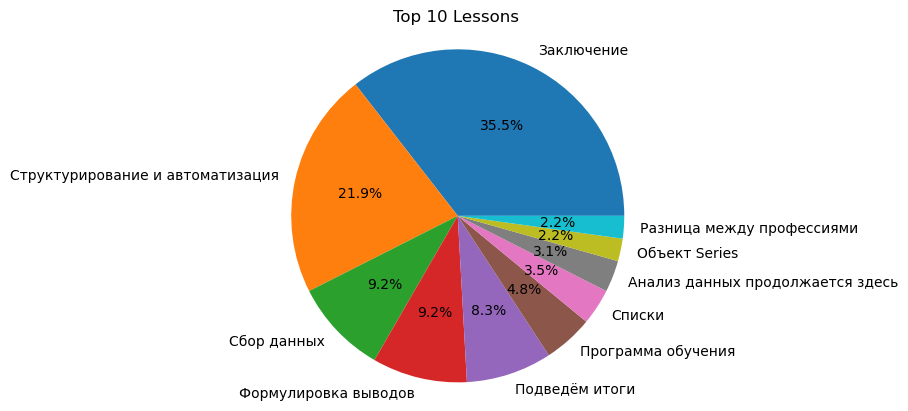

In [6]:
cnt = 10
piedf = df_names.head(cnt)
# otherdf = pd.DataFrame(data=[['other', df_names.tail(df_names.shape[0] - cnt)['cnt'].sum()]],
#                        columns=['lesson_name', 'cnt'])
# piedf = pd.concat((piedf, otherdf))
#fig, ax = plt.subplots()
plt.pie(piedf['cnt'], labels=piedf['lesson_name'], autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.title(f'Top {cnt} Lessons')

In [7]:
df_names['lesson_name'].unique()

array(['Заключение', 'Структурирование и автоматизация', 'Сбор данных',
       'Формулировка выводов', 'Подведём итоги', 'Программа обучения',
       'Списки', 'Анализ данных продолжается здесь', 'Объект Series',
       'Разница между профессиями', 'Обработка дубликатов',
       'Раздельный сбор информационного мусора', 'Простые функции',
       'GIGO', 'Присваивание со сложением',
       'Презентация результатов исследования', 'Сокращения в условиях',
       'Перерыв', 'Переименование столбцов', 'Охота на мусор',
       'Получение данных', 'Списки списков', 'Сортировка по столбцу',
       'Операции с числами', 'Срезы', 'Строки', 'Суммирование в цикле',
       'Условный оператор', 'Фильтрация таблицы',
       'Формирование исходной таблицы',
       'Функции как инструмент организации кода',
       'Функции с несколькими аргументами', 'Функция format()', 'Циклы',
       'Циклы по спискам списков', 'Что означают вычисленные доли',
       'Оформление текста', 'Ошибки', 'Операторы and и or